# how to determine which parameters mostly affect a result? *A heart disease study*

In [1]:
# imports
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as profiling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## 1. Introduction
Heart disease is broad term used for diseases affecting the heart and circulatory system.
Heart disease is a major cause of disability and death all around the world.
Since heart is amongst the most vital organs of the body, its diseases affect the body altogether.

**Objective of this study**
1. Explore the kaggle's heart disease dataset using statistical inference and data analysis.
2. Explore different lassification algorithms for prediction using machine learning. 
3. Compare between the statistical inference results and the machine learning algorithms. 
4. hypothesize whether machine learning models learn statistically correlated features?


## 2. Data analysis
In this part, we will explore the data using statistical analysis and discover how different features of the data influence each other. 

In [2]:
# dataset loading
df = pd.read_csv('../proposal/heart.csv')

In [3]:
# get a summary of the data
print(df.describe().T)

           count        mean        std    min    25%    50%    75%    max
age       1025.0   54.434146   9.072290   29.0   48.0   56.0   61.0   77.0
sex       1025.0    0.695610   0.460373    0.0    0.0    1.0    1.0    1.0
cp        1025.0    0.942439   1.029641    0.0    0.0    1.0    2.0    3.0
trestbps  1025.0  131.611707  17.516718   94.0  120.0  130.0  140.0  200.0
chol      1025.0  246.000000  51.592510  126.0  211.0  240.0  275.0  564.0
fbs       1025.0    0.149268   0.356527    0.0    0.0    0.0    0.0    1.0
restecg   1025.0    0.529756   0.527878    0.0    0.0    1.0    1.0    2.0
thalach   1025.0  149.114146  23.005724   71.0  132.0  152.0  166.0  202.0
exang     1025.0    0.336585   0.472772    0.0    0.0    0.0    1.0    1.0
oldpeak   1025.0    1.071512   1.175053    0.0    0.0    0.8    1.8    6.2
slope     1025.0    1.385366   0.617755    0.0    1.0    1.0    2.0    2.0
ca        1025.0    0.754146   1.030798    0.0    0.0    0.0    1.0    4.0
thal      1025.0    2.323

### Dictionary: 
1. age: the age of a person (counted in years)
2. sex: biological sex of the person
    * 1 = male
    * 0 = female
3. cp: chest pain type
    * 0: typical angina
    * 1: atypical angina
    * 2: non-anginal pain
    * 3: asymptomatic
4. trestbps: resting blood pressure (mmHg - determined on admission to the hospital)
5. chol: serum cholestoral (mg/dl)
6. fbs: fasting blood sugar (is fbs greater than 120 mg/dl?)
    * 1 = true; 
    * 0 = false
7. restecg: resting electrocardiographic results
    * 0: normal
    * 1: ST-T wave abnormality
    * 2: Likely left ventricular hypertrophy
8. thalach: maximum heart rate achieved (beats per minute)
9. exang: exercise induced angina (binary parameter)
    * 1 = yes
    * 0 = no
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    * 0: up-sloping
    * 1: flat
    * 2: down-sloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 
    * 0 = error
    * 1 = fixed defect
    * 2 = normal 
    * 3 = reversable defect 
14. target (Lable): 
    * 0 = Healthy 
    * 1 = Sick

***Note on the target label:*** <br/>
Diagnosis of heart disease is based on angiographic disease status with the following parameter: 

Healthy: < 50% diameter narrowing <br/>
Sick:    > 50% diameter narrowing

### Preprocessing: 

In [4]:
### Null values
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

#### There are no null values 

In [5]:
# Feature renaming for clarity
df = df.rename(columns = {'cp':'chest_pain_type', 'trestbps':'resting_blood_pressure', 'chol': 'cholesterol','fbs': 'fasting_blood_sugar', 
                'restecg' : 'rest_electrocardiographic', 'thalach': 'max_heart_rate_achieved', 'exang': 'exercise_induced_angina',
                'oldpeak': 'st_depression', 'slope': 'st_slope', 'ca':'num_major_vessels', 'thal': 'thalassemia'}, errors="raise")

df['sex'][df['sex'] == 0] = 'female'
df['sex'][df['sex'] == 1] = 'male'

df['chest_pain_type'][df['chest_pain_type'] == 0] = 'typical angina'
df['chest_pain_type'][df['chest_pain_type'] == 1] = 'atypical angina'
df['chest_pain_type'][df['chest_pain_type'] == 2] = 'non-anginal pain'
df['chest_pain_type'][df['chest_pain_type'] == 3] = 'asymptomatic'

df['fasting_blood_sugar'][df['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
df['fasting_blood_sugar'][df['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

df['rest_electrocardiographic'][df['rest_electrocardiographic'] == 0] = 'normal'
df['rest_electrocardiographic'][df['rest_electrocardiographic'] == 1] = 'ST-T wave abnormality'
df['rest_electrocardiographic'][df['rest_electrocardiographic'] == 2] = 'left ventricular hypertrophy'

df['exercise_induced_angina'][df['exercise_induced_angina'] == 0] = 'no'
df['exercise_induced_angina'][df['exercise_induced_angina'] == 1] = 'yes'

df['st_slope'][df['st_slope'] == 0] = 'upsloping'
df['st_slope'][df['st_slope'] == 1] = 'flat'
df['st_slope'][df['st_slope'] == 2] = 'downsloping'

df['thalassemia'][df['thalassemia'] == 1] = 'fixed defect'
df['thalassemia'][df['thalassemia'] == 2] = 'normal'
df['thalassemia'][df['thalassemia'] == 3] = 'reversable defect'

print(df.dtypes)

age                            int64
sex                           object
chest_pain_type               object
resting_blood_pressure         int64
cholesterol                    int64
fasting_blood_sugar           object
rest_electrocardiographic     object
max_heart_rate_achieved        int64
exercise_induced_angina       object
st_depression                float64
st_slope                      object
num_major_vessels              int64
thalassemia                   object
target                         int64
dtype: object


In [6]:
# group numerial features together
numerical_features = ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels']
# group binary features together
binary_features = ['sex', 'fasting_blood_sugar', 'exercise_induced_angina', 'target']
# group categorical features together
categorical_features = ['chest_pain_type', 'rest_electrocardiographic', 'st_slope', 'thalassemia'] + binary_features

### Analysis

Text(0.5, 1.05, 'Target variable distribution')

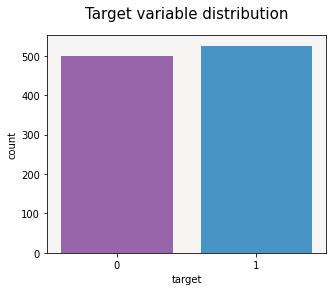

In [7]:
# distribution of sick vs healthy personal in the dataset.
colors = ["#9b59b6", "#3498db"]
plt.figure(figsize=(5, 4))
total = float(len(df))
ax = sns.countplot(df['target'], palette=colors)
ax.set_facecolor('#F6F5F4')
ax.set_title('Target variable distribution', fontsize=15, y=1.05)

In [8]:
print(df.target.value_counts())

1    526
0    499
Name: target, dtype: int64


#### We can see that the dataset is quite balanced with:
- 526 sick personal 
- 499 healthy personal

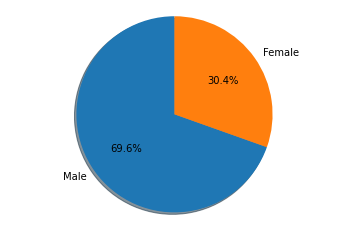

In [9]:
# distribution of gender in the dataset.
labels = 'Male', 'Female'
explode = (0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(df.sex.value_counts(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

### We can see that the dataset consists of:
- 69.6% male  
- 30.4% female

Text(0.5, 0.98, 'Numerical features affect on target')

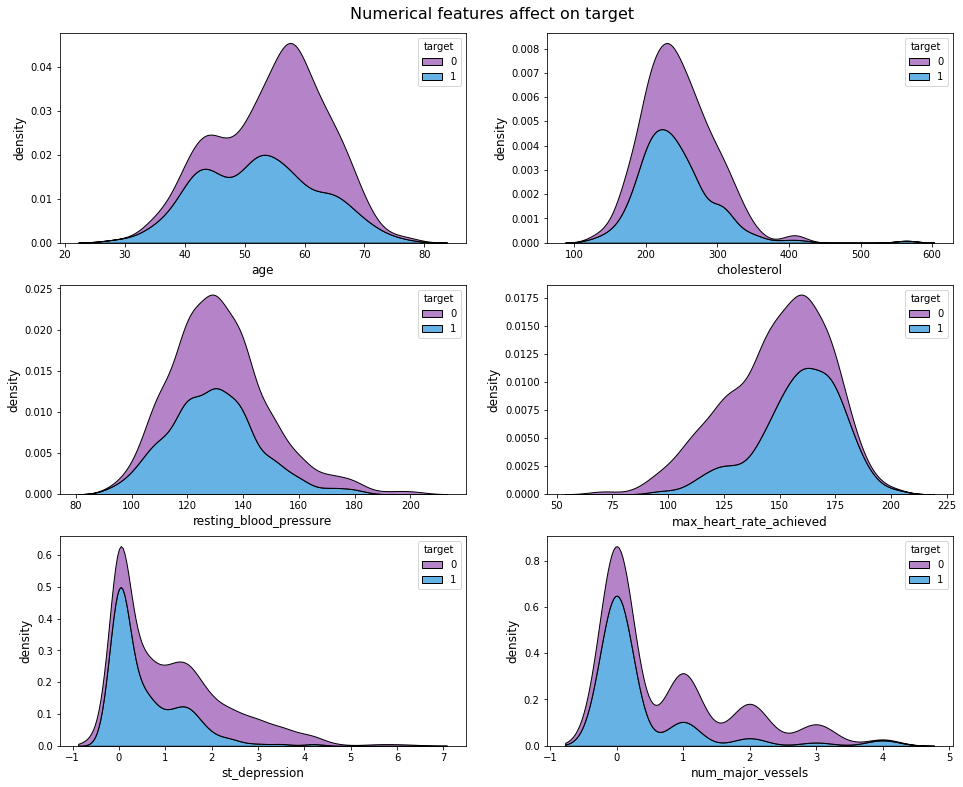

In [10]:
colors = ["#9b59b6", "#3498db"]
fig, ax = plt.subplots(3, 2, figsize=(16, 12))   
fig.subplots_adjust(top=0.95)
for idx, feature in enumerate(numerical_features):
    plt.subplot(3, 2, idx + 1)
    ax = sns.kdeplot(data=df, x=feature, hue="target", multiple="stack", palette=colors) 
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel("density", fontsize=12)
plt.suptitle('Numerical features affect on target' ,fontsize = 16)

Text(0.5, 0.98, 'Categorical features affect on target')

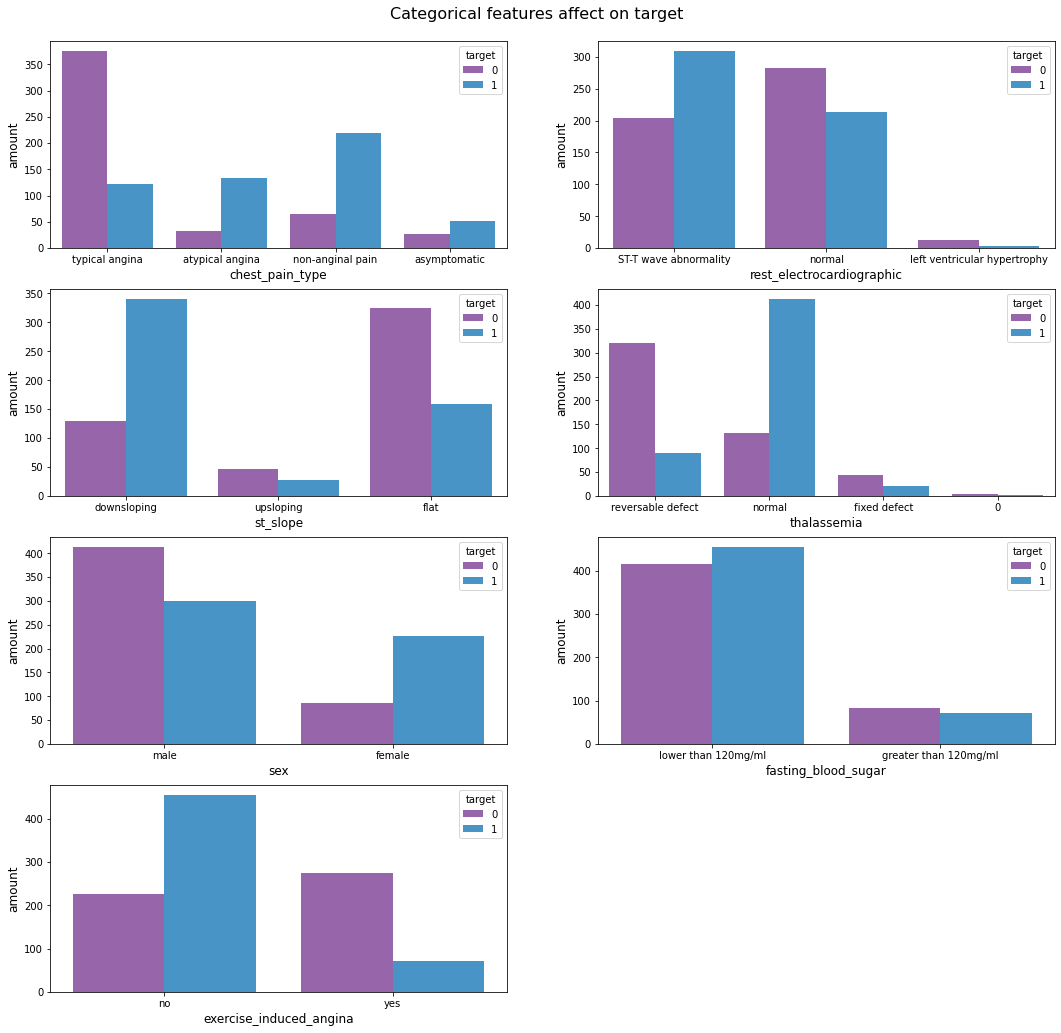

In [11]:
fig, ax = plt.subplots(4, 2, figsize=(18, 16))    
fig.subplots_adjust(top=0.95)
ax.flat[7].set_visible(False)
for idx, feature in enumerate(categorical_features):
    plt.subplot(4, 2, idx + 1)
    ax = sns.countplot(data=df, x=feature, hue="target", palette=colors) 
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel("amount", fontsize=12)
plt.suptitle('Categorical features affect on target' ,fontsize = 16)


### Machine learning

In [12]:
# separating features and labels
features = df.iloc[:, 0:-1]
labels = df.iloc[:, -1]

In [13]:
# spltting the dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state=1)

In [14]:
# logistic regression classifier
lr = LogisticRegression(max_iter = 1000, random_state=1)
lr.fit(x_train, y_train)
lr_score = lr.score(x_test, y_test)
print("Score: " + str(lr_score))
print("Coefficients: " + str(lr.coef_))


ValueError: could not convert string to float: 'female'

In [ ]:
clms = df.columns.drop(['target'])
lr_coef = pd.DataFrame(lr.coef_, columns = clms)
coeff = pd.melt(lr_coef)
ax = sns.barplot(y = coeff.variable, x = coeff.value)